# Red Wine Quality Project
***
***

# Goal
***
- Predict the quality of red wines based on various physiochemical attributes

# Setup
***

In [1]:
# establishing environment
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.ticker as mtick

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

# Acquire
Acquiring the data for this project
***

In [2]:
# acquiring data from local csv
wines = pd.read_csv('winequality-red.csv')

wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Prepare
Preparing the data for this project

## Checking for nulls and data types

In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


- No nulls
- Data types are appropriate for anticipated operations

## Changing spaces in column names to '_'

In [4]:
# replacing spaces with underscores in column names
wines.columns = wines.columns.str.replace(' ', '_')

## Changing all column names to be completed lowercase

In [5]:
# lowercasing all column names
wines.columns = wines.columns.str.lower()

## Outliers
After reviewing the data in-depth for outliers, I believe that the outliers are legitimate values. I don't want to remove non-erroneous data so I'm leaving the outliers in, with their original values.

## Binning Wines by Quality (1 - 5 = Bad, 6 - 10 = Good)
This variable will serve as the target variable

In [6]:
# creating boolean columns to reflect good and bad wines
wines['is_good_wine']= np.where(wines.quality >= 6, 1, 0)

# adding column strictly for use in plotting
# text column is useful for plotting so I don't have to customize labels
wines['good_or_bad']= np.where(wines.quality >= 6, 'Good', 'Bad')

# dropping 'quality' column since I have a binned version
wines.drop(columns = 'quality', inplace = True)

## Splitting data

In [7]:
# splitting data
train_validate, test = train_test_split(wines, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

## Scaling data

In [8]:
# creating list of DFs
df_list = [train, validate, test]
# creating empty list to hold names of columns to scale
cols_to_scale_l = []
# creating empty list to hold names of scaled columns
scaled_cols_l = []

# iterating through each column to be scaled of each df
for df in df_list:
    for col in df:
        if col != 'is_good_wine' and col != 'good_or_bad':
            # making temporary variable that holds current column name concatenated with '_s' at the end
            scaled_col_name = col + '_s'
            # appending col name to list
            cols_to_scale_l.append(col)
            # appending concatenated col name to list
            scaled_cols_l.append(scaled_col_name)
            # adding column with concatenated col name to current df
            df[scaled_col_name] = 0
            
# creating scaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fitting scaler to train column and scaling after
train[scaled_cols_l] = scaler.fit_transform(train[cols_to_scale_l])

# scaling data in validate and test dataframes
validate[scaled_cols_l] = scaler.transform(validate[cols_to_scale_l])
test[scaled_cols_l] = scaler.transform(test[cols_to_scale_l])

## Sorting columns

In [9]:
# moving 'is_good_wine' and 'good_or_bad' columns to end of each df
for df in df_list:
    quality_col = df.pop('is_good_wine')
    good_or_bad_col = df.pop('good_or_bad')
    df['good_or_bad'], df['is_good_wine'] = good_or_bad_col, quality_col

# Explore
Exploring the data to find insights about what drives wine quality
***

## General Exploration

### Creating Barplot that reflects percentage of each wine type (good vs bad)

In [10]:
wine_quality_counts = pd.DataFrame(train.good_or_bad.value_counts())

wine_quality_counts

,good_or_bad
Good,483
Bad,412


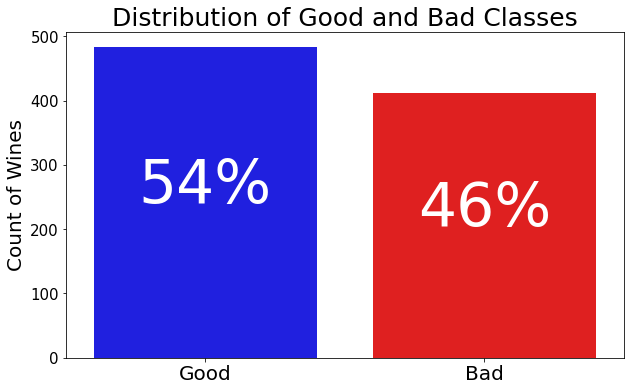

In [11]:
# creating plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = wine_quality_counts, x = wine_quality_counts.index, y='good_or_bad', palette = ['blue', 'red'])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel('Count of Wines', fontsize = 20)
plt.title('Distribution of Good and Bad Classes', fontsize = 25)

# adding % value to middle of each column
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.0%}'.format((height / total)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- The split between bad and good wines is fairly even with only an 8% difference between them

### Creating heatmap of all scaled variables and quality

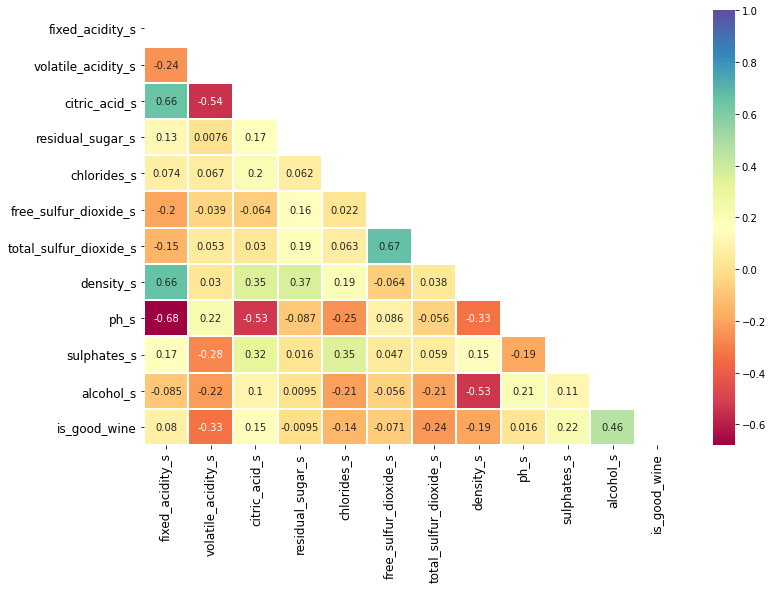

In [12]:
# creating empty list
heatmap_cols = []

# creating list of scaled variables and target variable
for col in train:
    if col[-2:] == '_s' or col == 'is_good_wine':
        heatmap_cols.append(col)

# creating df from list of columns
heatmap_df = train[heatmap_cols]

# calculating correlation values between variables
corr_matrix = heatmap_df.corr()

# creating mask to hide half duplicate variable pairings in heatmap
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# plotting heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix, cmap = 'Spectral', annot = True, mask = mask, linewidths = 1, linecolor = 'white')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

- Weak-to-Moderate negative correlation with good wine 
    - Chlorides (-.14)
    - Total_sulfure_dioxide (-.24)
    - Density (-.19)


- Weak-to-Moderate positive correlation with good wine 
    - Citric Acid (.15)
    - Sulphates (.22)


- Moderate-to-Strong negative correlation with good wine 
    - Volatile_acidity (-.33)


- Strong positive correlation with good wine 
    - Alcohol (.46)
    
    
- With these variables being noted, my initial iteration of this project will focus solely on these variables but I may explore the more weakly correlated variables at a later time

## Focused Exploration: Chlorides

### Visualization (Swarmplot) - Chlorides

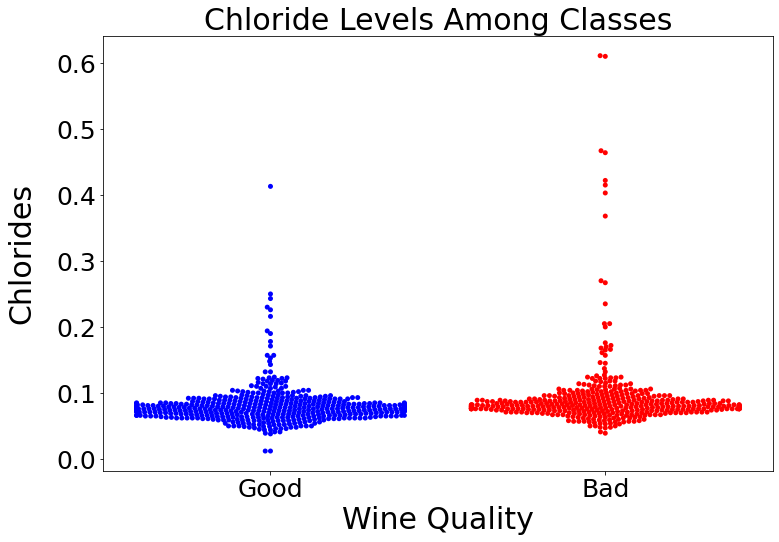

In [13]:
# creating swarmplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["chlorides"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Chlorides', fontsize = 30, labelpad = 20)
plt.title('Chloride Levels Among Classes', fontsize = 30)

plt.show()

- Bad wines appear to have more wines past the .3 mark than good wines
- Good wines have 2 wines that have almost no chlorides

### Visualization (Barplot) - Chlorides

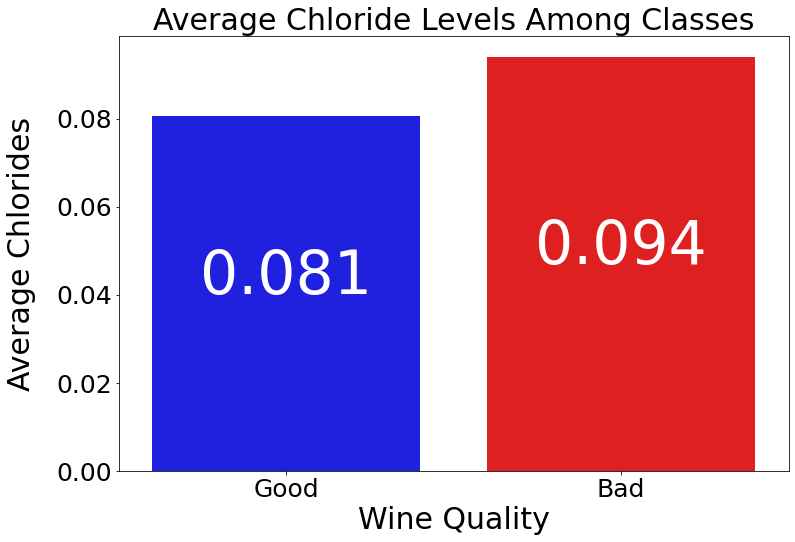

In [14]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["chlorides"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Chlorides', fontsize = 30, labelpad = 20)
plt.title('Average Chloride Levels Among Classes', fontsize = 30)

# adding annotations for chloride levels
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.2}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- Chloride levels are slightly higher in bad wines
    - Coincides with value in heatmap (-.14) which reflected an inverse relationship between chlorides and wine quality

### Hypothesis Test - Chlorides

H0: The average chloride level of good wines is equal to or greater than that of bad wines
<br>
Ha: The average chloride level of good wines is lower than that of bad wines

In [15]:
# separating chloride values into separate series' for good and bad wines
good_wine_chlorides = train[train.is_good_wine == 1]['chlorides']
bad_wine_chlorides = train[train.is_good_wine == 0]['chlorides']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_chlorides, bad_wine_chlorides)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t < 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 8.297756394839192e-06
t = -4.330047402063806

I reject the null hypothesis


- Since p is less than alpha and t is negative (in a "less than" test), I reject the null hypothesis
- This is further evidence that good wines have lower chloride levels on average than bad wines

## Focused Exploration: Total Sulfur Dioxide

### Visualization (Swarmplot) - Total Sulfure Dioxide

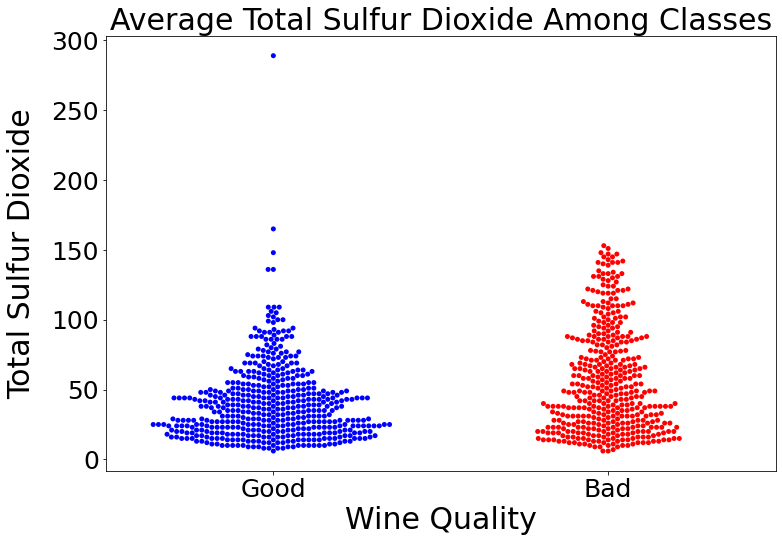

In [16]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["total_sulfur_dioxide"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Total Sulfur Dioxide', fontsize = 30, labelpad = 15)
plt.title('Average Total Sulfur Dioxide Among Classes', fontsize = 30)

plt.show()

- Good wines have only 5 wines with more than ~110 total sulfur dioxide, while bad wines have quite a few more
    - Despite this, there is a good wine with nearly 300 total sulfur dioxide

### Visualization (Barplot) - Total Sulfure Dioxide

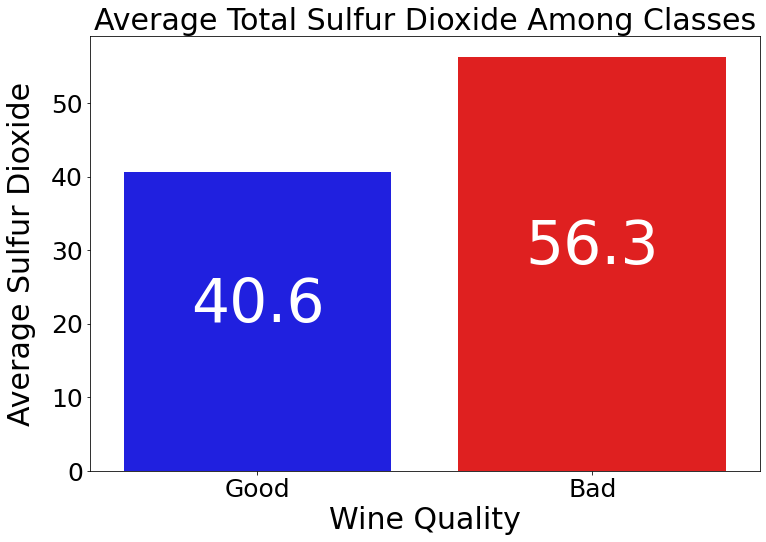

In [17]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["total_sulfur_dioxide"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Sulfur Dioxide', fontsize = 30, labelpad = 15)
plt.title('Average Total Sulfur Dioxide Among Classes', fontsize = 30)

# adding annotations 
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- Total sulfur dioxide levels are higher in bad wines
    - Coincides with value in heatmap (-.24) which reflected an inverse relationship between total sulfur dioxide and wine quality

### Hypothesis Test - Total Sulfur Dioxide
H0: The average total sulfur dioxide level of good wines is equal to or greater than those of bad wines
<br>
Ha: The average total sulfur dioxide level of good wines is lower than that of bad wines

In [18]:
# separating total sulfur dioxide values into separate series' for good and bad wines
good_wine_tsd = train[train.is_good_wine == 1]['total_sulfur_dioxide']
bad_wine_tsd = train[train.is_good_wine == 0]['total_sulfur_dioxide']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_tsd, bad_wine_tsd)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t < 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 3.9797677661960504e-13
t = -7.268015433088905

I reject the null hypothesis


- Since p is less than alpha and t is negative (in a "less than" test), I reject the null hypothesis
- This is further evidence that good wines have lower total sulfur dioxide levels on average than bad wines

## Focused Exploration: Density

### Visualization (Swarmplot) - Density

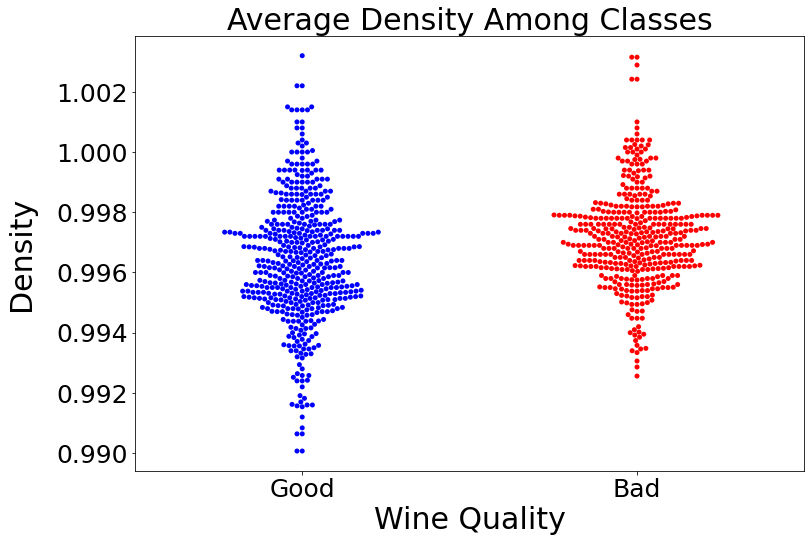

In [19]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["density"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Density', fontsize = 30, labelpad = 20)
plt.title('Average Density Among Classes', fontsize = 30)

plt.show()

- The density values of both good and bad wines mainly range from ~.992 to ~1.001
- However, good wines have more wines that extend past both end points of this range than bad wines

### Visualization (Barplot) - Density

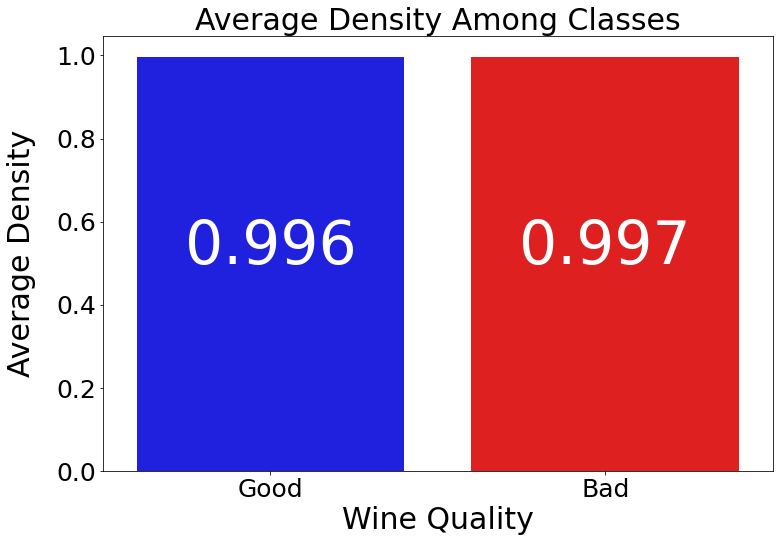

In [20]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["density"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Density', fontsize = 30, labelpad = 20)
plt.title('Average Density Among Classes', fontsize = 30)

# adding annotations
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- The average density levels within both good and bad wines are virtually equal

### Hypothesis Test - Density
H0: The average density of good wines is equal to or greater than that of bad wines
<br>
Ha: The average density of good wines is lower than that of bad wines

In [21]:
# separating density values into separate series' for good and bad wines
good_wine_density = train[train.is_good_wine == 1]['density']
bad_wine_density = train[train.is_good_wine == 0]['density']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_density, bad_wine_density)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t < 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 2.163947173496968e-09
t = -5.929949805100864

I reject the null hypothesis


- Since p is less than alpha and t is negative (in a "less than" test), I reject the null hypothesis
- This is further evidence that good wines have lower densities on average than bad wines

## Focused Exploration: Citric Acid
### Visualization (Swarmplot) - Citric Acid

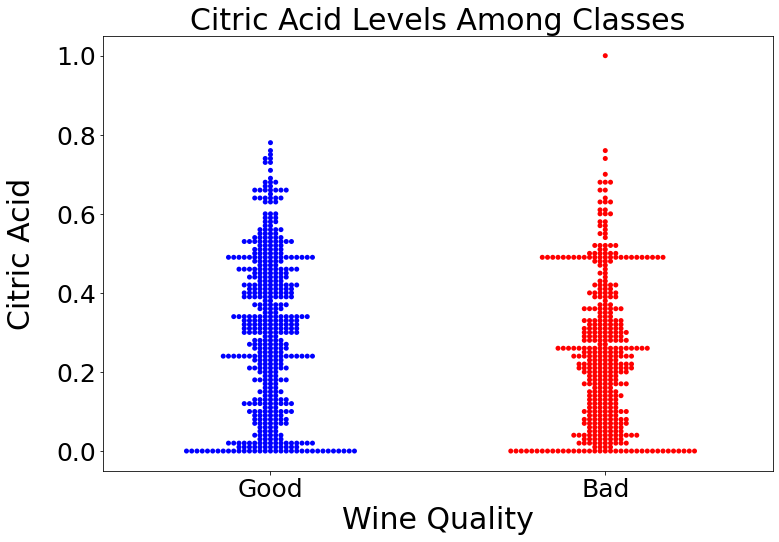

In [22]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["citric_acid"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Citric Acid', fontsize = 30, labelpad = 20)
plt.title('Citric Acid Levels Among Classes', fontsize = 30)

plt.show()

- Good wines appear to have slightly higher citric acid values than bad wines in general
    - Good wines seem to have more wines above the .3 mark than bad wines (particularly in the ~.3 - ~.6 range)
- A majority of bad wines appear to have citric acid values in the 0 - ~.25 range, the area below the concentration of good wines 
    - Interestingly, there is 1 bad wine with an extremely high citric acid value of 1

### Visualization (Barplot) - Citric Acid

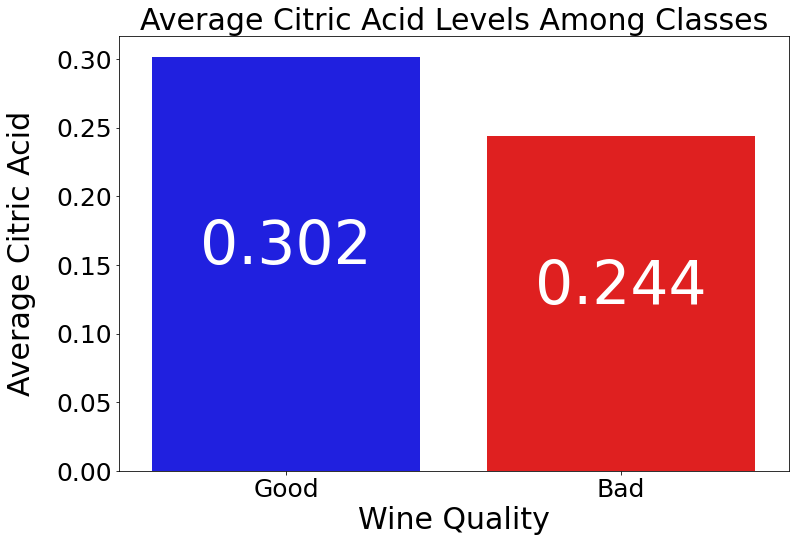

In [23]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["citric_acid"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Citric Acid', fontsize = 30, labelpad = 20)
plt.title('Average Citric Acid Levels Among Classes', fontsize = 30)

# adding annotations
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- On average, good wines have citric acid values roughly .06 higher than bad wines

### Hypothesis Test - Citric Acid
H0: The average citric acid level of good wines is equal to or less than those of bad wines
<br>
Ha: The average citric acid level of good wines is greater than those of bad wines

In [24]:
# separating citric acid values into separate series' for good and bad wines
good_wine_ca = train[train.is_good_wine == 1]['citric_acid']
bad_wine_ca = train[train.is_good_wine == 0]['citric_acid']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_ca, bad_wine_ca)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t > 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 4.045087796041095e-06
t = 4.489051029042681

I reject the null hypothesis


- Since p is less than alpha and t is positive (in a "greater than" test), I reject the null hypothesis
- This is further evidence that good wines have greater citric acids on average than bad wines

## Focused Exploration: Sulphates
### Visualization (Swarmplot) - Sulphates

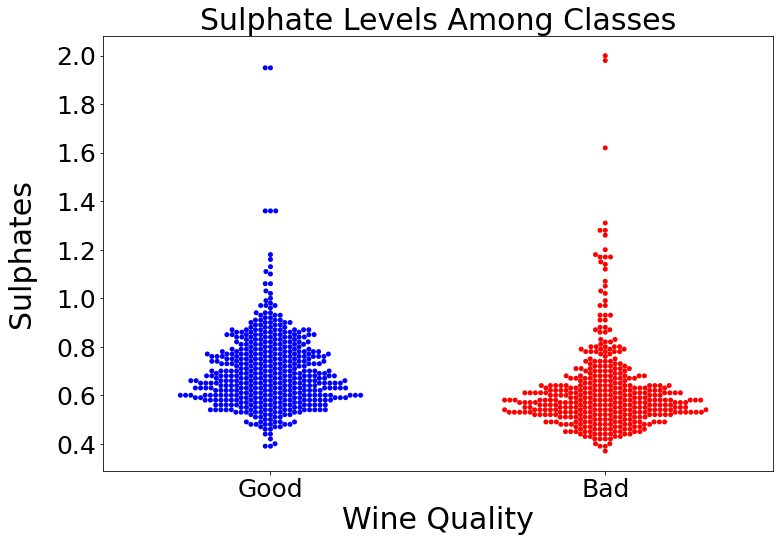

In [25]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["sulphates"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Sulphates', fontsize = 30, labelpad = 20)
plt.title('Sulphate Levels Among Classes', fontsize = 30)

plt.show()

- Generally, good wines appear to have higher sulphate values than bad wines
    - Good wines outnumber bad wines in the ~.7 - ~.9 range
	- Conversely, bad wines appear to outnumber good wines in the ~.5 - ~.6 range
- Despite this difference, both types each have 2 wines with sulphate levels around 2

### Visualization (Barplot) - Sulphates

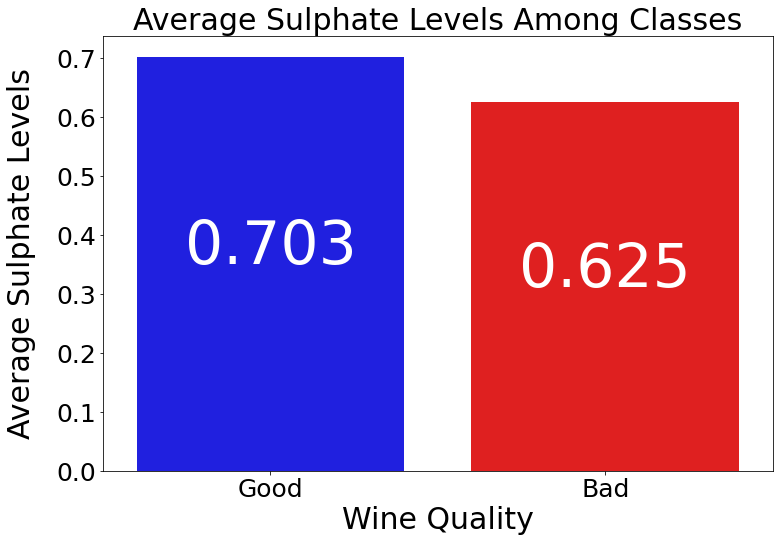

In [26]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["sulphates"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Sulphate Levels', fontsize = 30, labelpad = 20)
plt.title('Average Sulphate Levels Among Classes', fontsize = 30)

# adding annotations
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- On average, good wines have sulphate values .08 higher than bad wines

### Hypothesis Test - Sulphates
H0: The average sulphate levels of good wines are equal to or less than those of bad wines
<br>
Ha: The average sulphate levels of good wines are greater than those of bad wines

In [27]:
# separating sulphate values into separate series' for good and bad wines
good_wine_sulphates = train[train.is_good_wine == 1]['sulphates']
bad_wine_sulphates = train[train.is_good_wine == 0]['sulphates']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_sulphates, bad_wine_sulphates)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t > 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 3.964260601512552e-11
t = 6.581545550489116

I reject the null hypothesis


- Since p is less than alpha and t is positive (in a "greater than" test), I reject the null hypothesis
- This is further evidence that good wines have greater sulphate levels on average than bad wines

## Focused Exploration: Volatile Acidity
### Visualization (Swarmplot) - Volatile Acidity

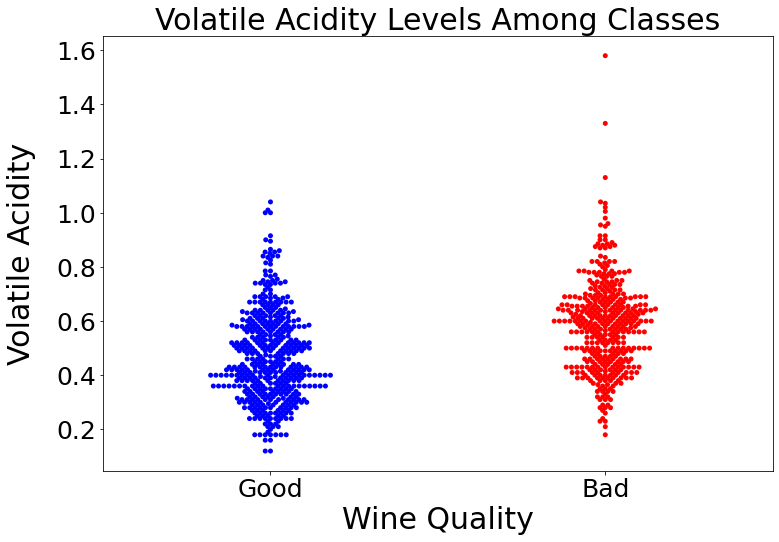

In [28]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["volatile_acidity"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Volatile Acidity', fontsize = 30, labelpad = 20)
plt.title('Volatile Acidity Levels Among Classes', fontsize = 30)

plt.show()

- Good wines appear to have lower volatile acidity values than bad wines on average
    - At around the .4 mark is where a major split among the 2 wine types appears to occur
    - Good wines appear to have more data points below the .4 mark
    - Bad wines appear to have more data points above the .4 mark

### Visualization (Barplot) - Volatile Acidity

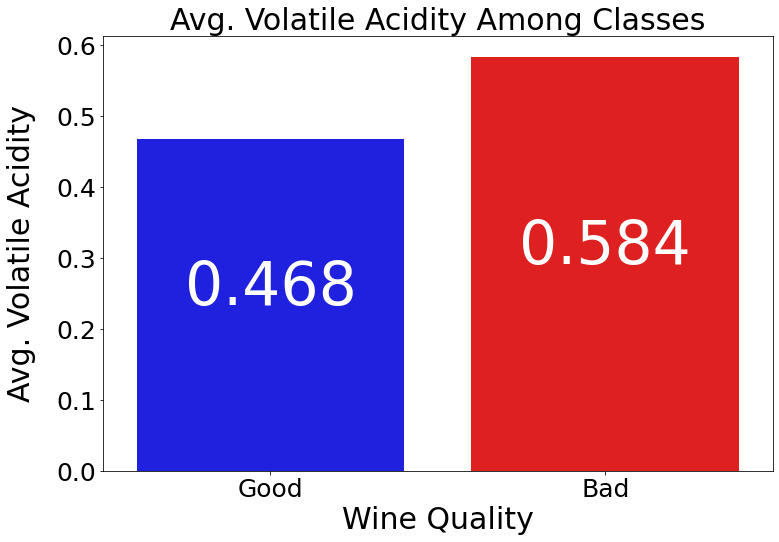

In [29]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["volatile_acidity"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Avg. Volatile Acidity', fontsize = 30, labelpad = 20)
plt.title('Avg. Volatile Acidity Among Classes', fontsize = 30)

# adding annotations
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- On average, good wines have volatile acidity levels that are .12 lower than bad wines

### Hypothesis Test - Volatile Acidity
H0: The average volatile acidity of good wines is equal to or greater than that of bad wines
<br>
Ha: The average volatile acidity of good wines is less than that of bad wines

In [30]:
# separating volatile acidity values into separate series' for good and bad wines
good_wine_va = train[train.is_good_wine == 1]['volatile_acidity']
bad_wine_va = train[train.is_good_wine == 0]['volatile_acidity']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_va, bad_wine_va)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t < 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 3.598112330058716e-24
t = -10.370191863496094

I reject the null hypothesis


- Since p is less than alpha and t is negative (in a "less than" test), I reject the null hypothesis
- This is further evidence that good wines have lower volatile acidity on average than bad wines

## Focused Exploration: Alcohol
### Visualization (Swarmplot) - Alcohol

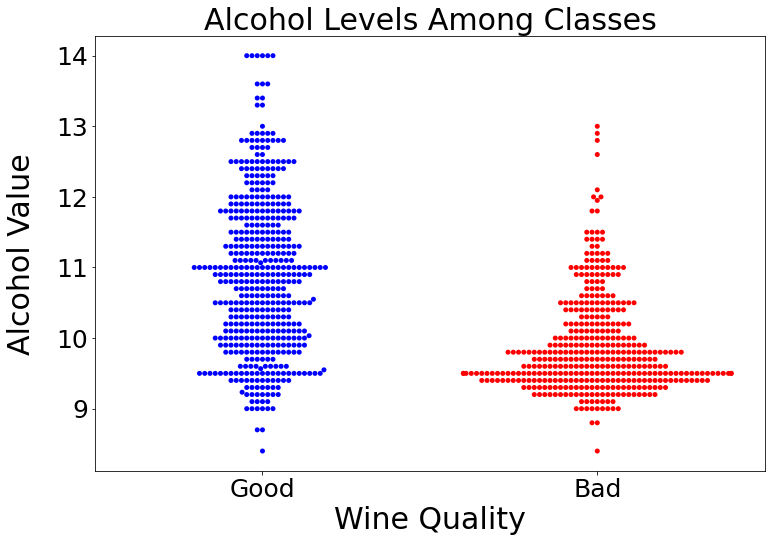

In [31]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.swarmplot(x = train["good_or_bad"], y = train["alcohol"], palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Alcohol Value', fontsize = 30, labelpad = 20)
plt.title('Alcohol Levels Among Classes', fontsize = 30)

plt.show()

- Good wines appear to have higher alcohol levels than bad wines on average
    - Good wines strongly outnumber bad wines in the 11 - 12.5 range
    - Bad wines have a higher concetration in the 9 - 10 range than good wines

### Visualization (Barplot) - Alcohol

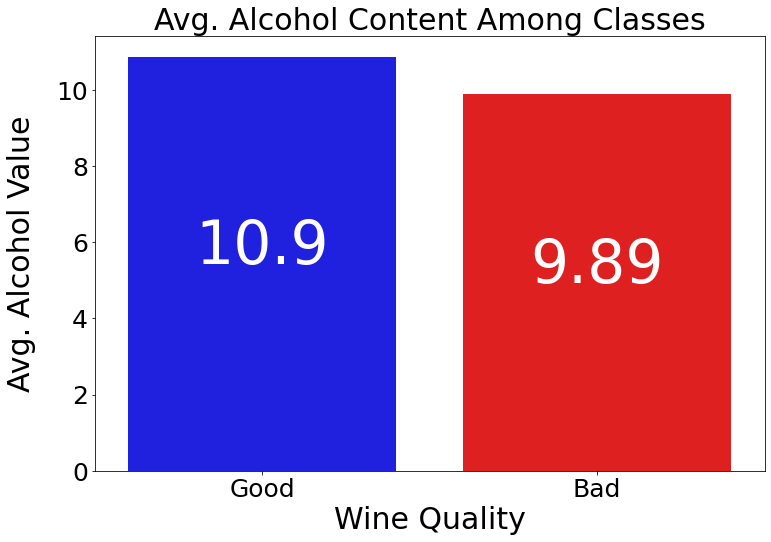

In [32]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["alcohol"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Avg. Alcohol Value', fontsize = 30, labelpad = 20)
plt.title('Avg. Alcohol Content Among Classes', fontsize = 30)

# adding annotations
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- On average, good wines have alcohol levels that are 1 greater than bad wines

### Hypothesis Test - Alcohol
H0: The average alcohol level of good wines is equal to or less than those of bad wines
<br>
Ha: The average alcohol level of good wines is greater than those of bad wines

In [33]:
# separating alochol values into separate series' for good and bad wines
good_wine_alochol = train[train.is_good_wine == 1]['alcohol']
bad_wine_alochol = train[train.is_good_wine == 0]['alcohol']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_alochol, bad_wine_alochol)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t > 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 1.8960191344328053e-48
t = 15.496489813514215

I reject the null hypothesis


- Since p is less than alpha and t is positive (in a "greater than" test), I reject the null hypothesis
- This is further evidence that good wines have greater alcohol conent on average than bad wines

# Modeling
***

## Choosing a performance metric
In this instance, all prediction outcomes (false positives, false negatives, true positives, true negatives) are equal in importance. That is to say, no one type of outcome is more costly than another. 

In light of this, I'll be guaging the performance of each model based on their respective __accuracies__ and __F1-scores__. 

__Accuracy__ reflects how often a correct prediction was made so it's useful in this case given tha all prediction outcomes are equally importance.

__F1 score__ is the harmonic mean of precision and recall, so it's useful in this case given that the classes (good and bad wines) are slightly imbalanced. 

## Creating RFE function

In [34]:
def rfe_ranker(df, algo):
    """
    Accepts dataframe and algorithm of choice. 
    Uses Recursive Feature Elimination to rank the given df's features in order of their usefulness in
    predicting logerror with the provided algorithm.
    """

    # fitting algo to features 
    algo.fit(df[['fixed_acidity_s', 'volatile_acidity_s',
       'citric_acid_s', 'residual_sugar_s', 'chlorides_s',
       'free_sulfur_dioxide_s', 'total_sulfur_dioxide_s', 'density_s', 'ph_s',
       'sulphates_s', 'alcohol_s']], df['is_good_wine'])

    # creating recursive feature elimination object and specifying to only rank 1 feature as best
    rfe = RFE(algo, 1)

    # using rfe object to transform features 
    x_rfe = rfe.fit_transform(df[['fixed_acidity_s', 'volatile_acidity_s',
       'citric_acid_s', 'residual_sugar_s', 'chlorides_s',
       'free_sulfur_dioxide_s', 'total_sulfur_dioxide_s', 'density_s', 'ph_s',
       'sulphates_s', 'alcohol_s']], df['is_good_wine'])

    # creating mask of selected feature
    feature_mask = rfe.support_

    # creating train df for rfe object 
    rfe_df = df[['fixed_acidity_s', 'volatile_acidity_s',
       'citric_acid_s', 'residual_sugar_s', 'chlorides_s',
       'free_sulfur_dioxide_s', 'total_sulfur_dioxide_s', 'density_s', 'ph_s',
       'sulphates_s', 'alcohol_s']]

    # creating list of the top features per rfe
    rfe_features = rfe_df.loc[:,feature_mask].columns.tolist()

    # creating ranked list 
    feature_ranks = rfe.ranking_

    # creating list of feature names
    feature_names = rfe_df.columns.tolist()

    # create df that contains all features and their ranks
    rfe_ranks_df = pd.DataFrame({'Feature': feature_names, 'Rank': feature_ranks})
    
    return rfe_ranks_df.sort_values('Rank')

## Train Set

### Isolating Target Variable

In [35]:
# isolating target variable, is_good_wine
y_train = train['is_good_wine']

### Baseline Model

In [36]:
# identifying dominant class
train.is_good_wine.value_counts()

1    483
0    412
Name: is_good_wine, dtype: int64

In [37]:
# creating baseline predictions
# BL will always predict a wine is good since thats the most common (dominant) class
train['baseline_prediction'] = 1

In [38]:
# calculating performance metrics
print(classification_report(y_train, train.baseline_prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       412
           1       0.54      1.00      0.70       483

    accuracy                           0.54       895
   macro avg       0.27      0.50      0.35       895
weighted avg       0.29      0.54      0.38       895



### Model 1 - XGBoost (Train)

### Model 1 - XGBoost - RFE

In [39]:
m1_variables = train[['fixed_acidity_s', 'volatile_acidity_s',
       'citric_acid_s', 'residual_sugar_s', 'chlorides_s',
       'free_sulfur_dioxide_s', 'total_sulfur_dioxide_s', 'density_s', 'ph_s',
       'sulphates_s', 'alcohol_s', 'is_good_wine']]

rfe_ranker(m1_variables, XGBClassifier(eval_metric = 'error'))

,Feature,Rank
10,alcohol_s,1
9,sulphates_s,2
6,total_sulfur_dioxide_s,3
1,volatile_acidity_s,4
7,density_s,5
8,ph_s,6
4,chlorides_s,7
0,fixed_acidity_s,8
3,residual_sugar_s,9
5,free_sulfur_dioxide_s,10


### Model 1A - XGBoost - Top 3 Features

In [40]:
# selecting features for model predictions and isolate target variable
x_m1a_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s']]
y_m1a_train = train[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1a_train, y_m1a_train)

# predicting wine class
train['model_1a_pred'] = xgc.predict(x_m1a_train)

# printing model prediction metrics
print(classification_report(y_m1a_train, train.model_1a_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       412
           1       0.99      0.98      0.99       483

    accuracy                           0.98       895
   macro avg       0.98      0.98      0.98       895
weighted avg       0.98      0.98      0.98       895



### Model 1B - XGBoost - Top 5 Features

In [59]:
# selecting features for model predictions and isolate target variable
x_m1b_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s']]
y_m1b_train = train[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1b_train, y_m1b_train)

# predicting wine class
train['model_1b_pred'] = xgc.predict(x_m1b_train)

# printing model prediction metrics
print(classification_report(y_m1b_train, train.model_1b_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       483

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895



### Model 1C - XGBoost - Top 7 Features

In [60]:
# selecting features for model predictions and isolate target variable
x_m1c_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s', 'ph_s', 'chlorides_s']]
y_m1c_train = train[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1c_train, y_m1c_train)

# predicting wine class
train['model_1c_pred'] = xgc.predict(x_m1c_train)

# printing model prediction metrics
print(classification_report(y_m1c_train, train.model_1c_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       483

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895



### Model 2 - Random Forest (Train)

### Model 2 - Random Forest - RFE

In [42]:
m2_variables = train[['fixed_acidity_s', 'volatile_acidity_s',
       'citric_acid_s', 'residual_sugar_s', 'chlorides_s',
       'free_sulfur_dioxide_s', 'total_sulfur_dioxide_s', 'density_s', 'ph_s',
       'sulphates_s', 'alcohol_s', 'is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

rfe_ranker(m2_variables, rf)

,Feature,Rank
1,volatile_acidity_s,1
10,alcohol_s,2
6,total_sulfur_dioxide_s,3
9,sulphates_s,4
7,density_s,5
4,chlorides_s,6
8,ph_s,7
0,fixed_acidity_s,8
2,citric_acid_s,9
5,free_sulfur_dioxide_s,10


### Model 2A - Random Forest - Top 3 Features

In [43]:
# selecting features for model predictions and isolate target variable
x_m2a_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s']]
y_m2a_train = train[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2a_train, y_m2a_train)

# predicting wine class
train['model_2a_pred'] = rf.predict(x_m2a_train)

# printing model prediction metrics
print(classification_report(y_m2a_train, train.model_2a_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       483

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895



### Model 2B - Random Forest - Top 5 Features

In [61]:
# selecting features for model predictions and isolate target variable
x_m2b_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s']]
y_m2b_train = train[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2b_train, y_m2b_train)

# predicting wine class
train['model_2b_pred'] = rf.predict(x_m2b_train)

# printing model prediction metrics
print(classification_report(y_m2b_train, train.model_2b_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       483

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895



### Model 2C - Random Forest - Top 7 Features

In [75]:
# selecting features for model predictions and isolate target variable
x_m2c_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s']]
y_m2c_train = train[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2c_train, y_m2c_train)

# predicting wine class
train['model_2c_pred'] = rf.predict(x_m2c_train)

# printing model prediction metrics
print(classification_report(y_m2c_train, train.model_2c_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       483

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895



### Model 2D - Random Forest - Top 8 Features

In [79]:
# selecting features for model predictions and isolate target variable
x_m2d_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s', 'fixed_acidity_s']]
y_m2d_train = train[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2d_train, y_m2d_train)

# predicting wine class
train['model_2d_pred'] = rf.predict(x_m2d_train)

# printing model prediction metrics
print(classification_report(y_m2d_train, train.model_2d_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       483

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895



### Model 3 - K-Nearest Neighbors (Train)

### Model 3 - K-Nearest Neighbors - RFE

In [45]:
m3_variables = train[['fixed_acidity_s', 'volatile_acidity_s',
       'citric_acid_s', 'residual_sugar_s', 'chlorides_s',
       'free_sulfur_dioxide_s', 'total_sulfur_dioxide_s', 'density_s', 'ph_s',
       'sulphates_s', 'alcohol_s', 'is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

rfe_ranker(m3_variables, rf)

,Feature,Rank
1,volatile_acidity_s,1
10,alcohol_s,2
6,total_sulfur_dioxide_s,3
9,sulphates_s,4
7,density_s,5
4,chlorides_s,6
8,ph_s,7
0,fixed_acidity_s,8
2,citric_acid_s,9
5,free_sulfur_dioxide_s,10


### Model 3A - K-Nearest Neighbors - Top 3 Features

In [46]:
# selecting features for model predictions and isolate target variable
x_m3a_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s']]
y_m3a_train = train[['is_good_wine']]

# creating knn object
knn = KNeighborsClassifier()

# fitting model to train data
knn.fit(x_m3a_train, y_m3a_train)

# predicting wine class
train['model_3a_pred'] = knn.predict(x_m3a_train)

# printing model prediction metrics
print(classification_report(y_m3a_train, train.model_3a_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       412
           1       0.83      0.84      0.83       483

    accuracy                           0.82       895
   macro avg       0.82      0.82      0.82       895
weighted avg       0.82      0.82      0.82       895



### Model 3B - K-Nearest Neighbors - Top 5 Features

In [63]:
# selecting features for model predictions and isolate target variable
x_m3b_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s']]
y_m3b_train = train[['is_good_wine']]

# creating knn object
knn = KNeighborsClassifier()

# fitting model to train data
knn.fit(x_m3b_train, y_m3b_train)

# predicting wine class
train['model_3b_pred'] = knn.predict(x_m3b_train)

# printing model prediction metrics
print(classification_report(y_m3b_train, train.model_3b_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       412
           1       0.84      0.84      0.84       483

    accuracy                           0.83       895
   macro avg       0.82      0.82      0.82       895
weighted avg       0.83      0.83      0.83       895



### Model 3C - K-Nearest Neighbors - Top 7 Features

In [64]:
# selecting features for model predictions and isolate target variable
x_m3c_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s']]
y_m3c_train = train[['is_good_wine']]

# creating knn object
knn = KNeighborsClassifier()

# fitting model to train data
knn.fit(x_m3c_train, y_m3c_train)

# predicting wine class
train['model_3c_pred'] = knn.predict(x_m3c_train)

# printing model prediction metrics
print(classification_report(y_m3c_train, train.model_3c_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       412
           1       0.83      0.86      0.84       483

    accuracy                           0.83       895
   macro avg       0.83      0.83      0.83       895
weighted avg       0.83      0.83      0.83       895



## Validate Set

### Model 1A - XGBoost - Top 3 Features (Validate)

In [65]:
# selecting features for model predictions and isolate target variable
x_m1a_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s']]
y_m1a_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m1a_validate = validate[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s']]
y_m1a_validate = validate[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1a_train, y_m1a_train)

# predicting wine class
validate['model_1a_pred'] = xgc.predict(x_m1a_validate)

# printing model prediction metrics
print(classification_report(y_m1a_validate, validate.model_1a_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       187
           1       0.75      0.73      0.74       197

    accuracy                           0.73       384
   macro avg       0.73      0.73      0.73       384
weighted avg       0.73      0.73      0.73       384



### Model 1B - XGBoost - Top 5 Features (Validate)

In [67]:
# selecting features for model predictions and isolate target variable
x_m1b_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s']]
y_m1b_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m1b_validate = validate[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s']]
y_m1b_validate = validate[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1b_train, y_m1b_train)

# predicting wine class
validate['model_1b_pred'] = xgc.predict(x_m1b_validate)

# printing model prediction metrics
print(classification_report(y_m1b_validate, validate.model_1b_pred))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       187
           1       0.77      0.73      0.75       197

    accuracy                           0.75       384
   macro avg       0.75      0.75      0.75       384
weighted avg       0.75      0.75      0.75       384



### Model 1C - XGBoost - Top 7 Features (Validate)

In [68]:
# selecting features for model predictions and isolate target variable
x_m1c_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s', 'ph_s', 'chlorides_s']]
y_m1c_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m1c_validate = validate[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s', 'ph_s', 'chlorides_s']]
y_m1c_validate = validate[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1c_train, y_m1c_train)

# predicting wine class
validate['model_1c_pred'] = xgc.predict(x_m1c_validate)

# printing model prediction metrics
print(classification_report(y_m1c_validate, validate.model_1c_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       187
           1       0.80      0.77      0.78       197

    accuracy                           0.78       384
   macro avg       0.78      0.78      0.78       384
weighted avg       0.78      0.78      0.78       384



### Model 1D - XGBoost - Top 8 Features (Validate)

In [81]:
# selecting features for model predictions and isolate target variable
x_m1d_train = train[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s', 'ph_s', 'chlorides_s', 'fixed_acidity_s']]
y_m1d_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m1d_validate = validate[['alcohol_s', 'sulphates_s', 'total_sulfur_dioxide_s', 'volatile_acidity_s', 'density_s', 'ph_s', 'chlorides_s', 'fixed_acidity_s']]
y_m1d_validate = validate[['is_good_wine']]

# creating xgboost object
xgc = XGBClassifier(eval_metric = 'error')

# fitting model to train data
xgc.fit(x_m1d_train, y_m1d_train)

# predicting wine class
validate['model_1d_pred'] = xgc.predict(x_m1d_validate)

# printing model prediction metrics
print(classification_report(y_m1d_validate, validate.model_1d_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       187
           1       0.79      0.77      0.78       197

    accuracy                           0.78       384
   macro avg       0.78      0.78      0.78       384
weighted avg       0.78      0.78      0.78       384



### Model 2A - Random Forest - Top 3 Features (Validate)

In [71]:
# selecting features for model predictions and isolate target variable
x_m2a_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s']]
y_m2a_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m2a_validate = validate[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s']]
y_m2a_validate = validate[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2a_train, y_m2a_train)

# predicting wine class
validate['model_2a_pred'] = rf.predict(x_m2a_validate)

# printing model prediction metrics
print(classification_report(y_m2a_validate, validate.model_2a_pred))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       187
           1       0.77      0.80      0.78       197

    accuracy                           0.77       384
   macro avg       0.77      0.77      0.77       384
weighted avg       0.77      0.77      0.77       384



### Model 2B - Random Forest - Top 5 Features (Validate)

In [74]:
# selecting features for model predictions and isolate target variable
x_m2b_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s']]
y_m2b_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m2b_validate = validate[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s']]
y_m2b_validate = validate[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2b_train, y_m2b_train)

# predicting wine class
validate['model_2b_pred'] = rf.predict(x_m2b_validate)

# printing model prediction metrics
print(classification_report(y_m2b_validate, validate.model_2b_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       187
           1       0.77      0.78      0.77       197

    accuracy                           0.76       384
   macro avg       0.76      0.76      0.76       384
weighted avg       0.76      0.76      0.76       384



### Model 2C - Random Forest - Top 7 Features (Validate)

In [78]:
# selecting features for model predictions and isolate target variable
x_m2c_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s']]
y_m2c_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m2c_validate = validate[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s']]
y_m2c_validate = validate[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2c_train, y_m2c_train)

# predicting wine class
validate['model_2c_pred'] = rf.predict(x_m2c_validate)

# printing model prediction metrics
print(classification_report(y_m2c_validate, validate.model_2c_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       187
           1       0.81      0.80      0.80       197

    accuracy                           0.80       384
   macro avg       0.80      0.80      0.80       384
weighted avg       0.80      0.80      0.80       384



### Model 2D - Random Forest - Top 8 Features (Validate)

In [80]:
# selecting features for model predictions and isolate target variable
x_m2d_train = train[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s', 'fixed_acidity_s']]
y_m2d_train = train[['is_good_wine']]

# selecting features for model predictions and isolate target variable
x_m2d_validate = validate[['volatile_acidity_s', 'alcohol_s', 'total_sulfur_dioxide_s', 'sulphates_s', 'density_s', 'chlorides_s', 'ph_s', 'fixed_acidity_s']]
y_m2d_validate = validate[['is_good_wine']]

# creating random forest object
rf = RandomForestClassifier(random_state=123)

# fitting model to train data
rf.fit(x_m2d_train, y_m2d_train)

# predicting wine class
validate['model_2d_pred'] = rf.predict(x_m2d_validate)

# printing model prediction metrics
print(classification_report(y_m2d_validate, validate.model_2d_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       187
           1       0.80      0.78      0.79       197

    accuracy                           0.79       384
   macro avg       0.79      0.79      0.79       384
weighted avg       0.79      0.79      0.79       384

